In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy.fft import fft,ifft,rfft,irfft
import scipy.signal as sig
from scipy.interpolate import interp1d

We're going to simulate data discretely sampled in time. We need to set a sample rate in Hz. The highest resolvable frequency, the Nyquist frequency, is half the sample rate. We also need to decide how long the simulated data record should last.

In [3]:
sample_rate = 4096
nyquist = sample_rate/2
time_length_seconds = 512

## Generate fake Gaussian noise

The procedure for making colored Gaussian noise is:
 1. Generate white Gaussian noise by many independent draws from a normal distribution.
 1. Transform this to the frequency domain.
 1. Choose the spectrum you want to simulate, sampled at the same frequencies as the frequency-domain white noise.
 1. Multiply the FD white noise by the ASD of the desired spectrum.
 1. Transform this back to the time domain.
 1. Cut off the start and end of this data, to eliminate the filter wraparond. We cut off a quarter of the noise stream at either end, which should be more than enough with such a smooth PSD.

In [4]:
# Make the data twice as long so we can cut off the wrap-around
num_noise_samples=2*time_length_seconds*sample_rate
white_noise_fd=rfft(np.random.normal(size=num_noise_samples))
sim_freqs=np.arange(len(white_noise_fd))/(2.*time_length_seconds)

In [5]:
psd=(sim_freqs/40.)**-10+(sim_freqs/70.)**-4+0.5+1.397e-6*(sim_freqs)**2
# Put in a fake highpass around 8 Hz, so we don't have too much low frequency
to_bin=2*time_length_seconds
f_pass, f_min = 8., 10.
idx1=int(to_bin*f_pass)
idx2=int(to_bin*f_min)
psd[:idx1]=psd[idx2]*(sim_freqs[:idx1]/f_pass)**2
psd[idx1:idx2]=psd[idx2]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


In [6]:
colored_noise_td = np.sqrt(float(nyquist))*irfft(np.sqrt(psd)*white_noise_fd)
colored_noise_td = colored_noise_td[len(colored_noise_td)/4:-len(colored_noise_td)/4]

In [41]:
def welch_asd(data, fft_len_sec, overlap=0.5, window='hanning'):
    """Measure the ASD using the Welch method of averaging
    estimates on shorter overlapping segments of the data."""
    assert 0. <= overlap < 1.
    ff, tmp = sig.welch(data, fs=sample_rate, window=window,
                        nperseg=fft_len_sec*sample_rate,
                        noverlap=overlap*fft_len_sec*sample_rate)
    return ff, np.sqrt(tmp)

In [81]:
ff, measured_asd_bc = welch_asd(colored_noise_td, window='boxcar', fft_len_sec=4)
ff, measured_asd = welch_asd(colored_noise_td, window='hanning', fft_len_sec=4)

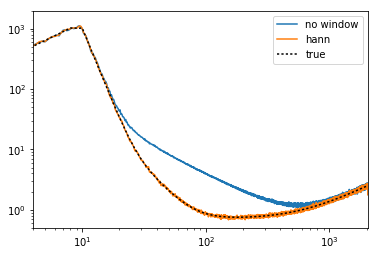

In [82]:
plt.loglog(ff, measured_asd_bc, label='no window')
plt.loglog(ff, measured_asd, label='hann')
plt.loglog(sim_freqs, np.sqrt(psd), c='k', ls=':', label='true')
plt.xlim(4,nyquist)
plt.ylim(0.5,2e3)
plt.legend(loc='upper right')

The estimate using the Hann window recovers the true spectrum very well. However, forgetting to use a window causes something called 'spectral leakage'. The large power from low frequencies leaks into the higher frequencies and the spectral estimate is wrong. This has a characteristic smooth, slowly falling shape. You can see that in the code above we use a 'boxcar' window; this is a rectangular window tht goes instantly from one to zero, and is the same as not using a window.

## Gaussian noise with lines

In [42]:
def line_at(f0, data):
    """Make a sinusoid at f0 Hz with the same length as data"""
    return np.sin(2.*np.pi*f0*np.arange(len(data))/sample_rate)

In [52]:
noise_with_lines = colored_noise_td\
                    + 100.*line_at(35.9, colored_noise_td)\
                    + 100.*line_at(36.7, colored_noise_td)

In [53]:
ff16, measured_asd_lines_bc = welch_asd(noise_with_lines, window='boxcar', fft_len_sec=16)
ff16, measured_asd_lines = welch_asd(noise_with_lines, window='hanning', fft_len_sec=16)

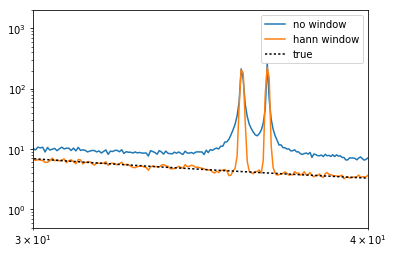

In [56]:
plt.loglog(ff16, measured_asd_lines_bc, label='no window')
plt.loglog(ff16, measured_asd_lines, label='hann window')
plt.loglog(sim_freqs, np.sqrt(psd), c='k', ls=':', label='true')
plt.xlim(30,40)
plt.ylim(0.5,2e3)
plt.legend(loc='upper right')

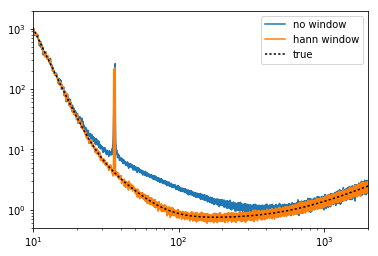

In [57]:
plt.loglog(ff16, measured_asd_lines_bc, label='no window')
plt.loglog(ff16, measured_asd_lines, label='hann window')
plt.loglog(sim_freqs, np.sqrt(psd), c='k', ls=':', label='true')
plt.xlim(10,2000)
plt.ylim(0.5,2e3)
plt.legend(loc='upper right')

I don't have much to say here for now, other than it's pretty easy to simulate calibration lines. Just add a sinusoid to Gaussian noise.